In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [67]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

dist = 50
z = 400
rho = 0.0
zenith = -np.pi/4
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
a = gamma_as
b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[3.80675453 5.83448708 2.46098011] [0.01780235 0.06579191 0.00494731]


In [49]:
from lib.cgamma import c_multi_gamma_prob, c_multi_gamma_mpe_prob
from lib.gamma_sf_approx import gamma_sf_fast_w_existing_coefficients, c_coeffs
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_midpoint2

In [50]:
@jax.jit
def c_gamma_sf_approx(x, a, b, c, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps1 = 30 # controls the support points in midpoint integration
    n_steps2 = 10
    n_steps3 = 10
    eps = 1.e-40

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)

    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0)

    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gamma_sf_fast_w_existing_coefficients(ymax, a, b, c) + gamma_sf_fast_w_existing_coefficients(ymin, a, b, c)
    #term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    
    
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    #x_int = jnp.linspace(ymin, ymax, n_steps+1, axis=-1)
    #dx = jnp.expand_dims(x_int[..., 1] - x_int[..., 0], axis=-1)

    mid_p1 = ymin + 0.01 * (ymax - ymin)
    mid_p2 = mid_p1 + 0.1 * (ymax - mid_p1)
    x_int = jnp.concatenate([
        jnp.linspace(ymin, mid_p1, n_steps2+1, axis=-1),
        jnp.linspace(mid_p1, mid_p2, n_steps3+1, axis=-1),
        jnp.linspace(mid_p2, ymax, n_steps1+1, axis=-1)
    ])

    dx = jnp.expand_dims(x_int[..., 1:] - x_int[..., :-1], axis=0)
    x_int = 0.5*(x_int[...,1:] + x_int[...,:-1])

    # add dimension to end for proper broadcasting during integration
    # and then integrate by brute force on even grid
    # todo: come up with something faster and more accurate?
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    term2 *= jnp.sum(y_int * dx, axis=-1)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=eps, max=1.0)


@jax.jit
def c_multi_gamma_sf_approx(x, mix_probs, a, b, c, sigma=3.0):
    probs = c_gamma_sf_approx(x, a, b, c, sigma=sigma)
    return jnp.sum(mix_probs * probs, axis=-1)

In [51]:
@jax.jit
def c_multi_gamma_mpe_prob_approx(x, mix_probs, a, b, n, c, sigma=3.0, delta=0.1):
    c = c_coeffs(a)
    p = c_multi_gamma_prob(x, mix_probs, a, b, sigma=sigma, delta=delta)
    sf = c_multi_gamma_sf_approx(x, mix_probs, a, b, c, sigma=sigma)
    return n * p * jnp.power(sf, n-1)

In [52]:
convolved_cgamma_mpe_prob_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob, (0, None, None, None, None, None, None), 0))
convolved_cgamma_mpe_prob_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_approx, (0, None, None, None, None, None, None, None), 0))
convolved_c_mpe_gamma_prob_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint2, (0, None, None, None, None, None), 0))

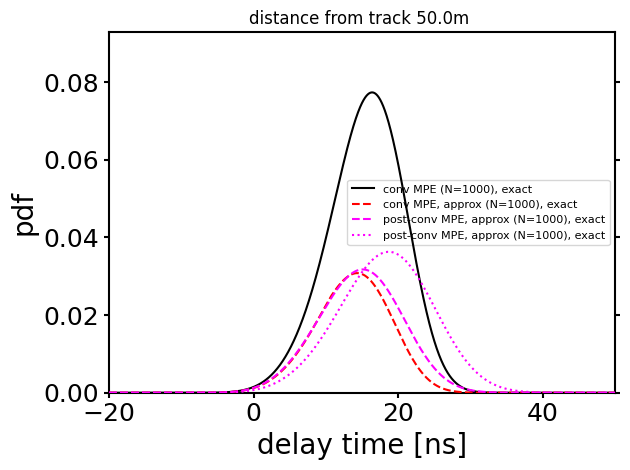

In [68]:
from matplotlib.pyplot import cm

n_p = 1000

fig, ax = plt.subplots()
xvals = np.linspace(-50, 50, 10000)

y_max = 0
ys_cgamma_mpe = convolved_cgamma_mpe_prob_v1d_x(xvals, mix_probs, a, b, n_p, jnp.array(3.0), jnp.array(0.1))
plt.plot(xvals, ys_cgamma_mpe, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='solid', zorder=105)
y_max = np.amax([y_max, np.nanmax(ys_cgamma_mpe)])

c = c_coeffs(a)
ys_cgamma_mpe_approx = convolved_cgamma_mpe_prob_approx_v1d_x(xvals, mix_probs, a, b, n_p, c, jnp.array(3.0), jnp.array(0.1))
plt.plot(xvals, ys_cgamma_mpe_approx, label=f'conv MPE, approx (N={n_p:.0f}), exact', color='red', linestyle='dashed', zorder=500)
y_max = np.amax([y_max, np.nanmax(ys_cgamma_mpe_approx)])

ys_c_mpe_gamma_approx1 = convolved_c_mpe_gamma_prob_approx_v1d_x(xvals, mix_probs, a, b, n_p, jnp.array(3.0))
plt.plot(xvals, ys_c_mpe_gamma_approx1, label=f'post-conv MPE, approx (N={n_p:.0f}), exact', color='magenta', linestyle='dashed', zorder=500)
y_max = np.amax([y_max, np.nanmax(ys_c_mpe_gamma_approx1)])

ys_c_mpe_gamma_approx2 = convolved_c_mpe_gamma_prob_approx_v1d_x(xvals, mix_probs, a, b, n_p/2, jnp.array(3.0))
plt.plot(xvals, ys_c_mpe_gamma_approx2, label=f'post-conv MPE, approx (N={n_p:.0f}), exact', color='magenta', linestyle='dotted', zorder=500)
y_max = np.amax([y_max, np.nanmax(ys_c_mpe_gamma_approx2)])


plot_args = {'xlim':[-20, 50],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [8]:
%timeit convolved_cgamma_mpe_prob_v1d_x(xvals, mix_probs, a, b, n_p, jnp.array(3.0), jnp.array(0.1))

9.91 ms ± 7.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit convolved_cgamma_mpe_prob_approx_v1d_x(xvals, mix_probs, a, b, n_p, c, jnp.array(3.0), jnp.array(0.1))

6.82 ms ± 6.46 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%timeit convolved_c_mpe_gamma_prob_approx_v1d_x(xvals, mix_probs, a, b, n_p, jnp.array(3.0))

8.21 ms ± 2.13 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
dx = xvals[1] - xvals[0]
np.sum(dx * ys_c_mpe_gamma_approx1)

Array(0.46072315, dtype=float64)

In [70]:
dx = xvals[1] - xvals[0]
np.sum(dx * ys_c_mpe_gamma_approx2)

Array(0.58966671, dtype=float64)